# Exploring Germinal Center phenotype in activated B cells

10X, only B cell populations from PBMCs

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata
import scipy
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


## Reading the B cell subset of 10X data 

(without outliers - removed manually in notebook S1)

In [4]:
# normalised, log transformed and scaled
# subsetted to HVGs
adata_B = sc.read('./adata_B_cells_reanalysed.h5ad')

In [5]:
# creating the full object (all genes) - only normalised and log transformed
adata_B_full = anndata.AnnData(X=adata_B.raw.X,
                            obs=adata_B.obs,
                            var=adata_B.raw.var,
                            obsm=adata_B.obsm)

## Reading in GC data from  [Milpied et al., Nature Immunology, 2018](https://www.nature.com/articles/s41590-018-0181-4#rightslink)

In [6]:
table_GC = pd.read_csv('./GC_data_Milpied/GSM3190075_humanBcells_matrixGeneCell.csv')

In [7]:
table_GC.set_index('UniqueCellID', inplace=True)

In [8]:
table_GC.shape

(859, 14311)

In [9]:
table_GC.columns

Index(['RP11-34P13.7', 'FO538757.2', 'AP006222.2', 'RP11-206L10.9',
       'LINC00115', 'FAM41C', 'RP11-54O7.1', 'NOC2L', 'RP11-54O7.17', 'HES4',
       ...
       'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'BX004987.4', 'AC145212.2',
       'AL592183.1', 'AL354822.1', 'AC004556.1', 'AC240274.1'],
      dtype='object', length=14311)

In [10]:
# the full object
adata_GC_full = anndata.AnnData(X=table_GC.values,
                            obs=list(table_GC.index),
                            var=table_GC.columns)

# so that actual genes are in the var_names
(adata_GC_full.var).columns = ['0']
(adata_GC_full.var).set_index('0', inplace=True)

#### Some basic QC on this data

In [11]:
# adding QC covariates
# Quality control - calculate QC covariates
adata_GC_full.obs['n_counts'] = adata_GC_full.X.sum(1)
adata_GC_full.obs['log_counts'] = np.log(adata_GC_full.obs['n_counts'])
adata_GC_full.obs['n_genes'] = (adata_GC_full.X > 0).sum(1)

# Extract mitochondial genes
mito_genes = [name for name in adata_GC_full.var_names if name.startswith('MT-')]
#for each cell compute fraction of counts in mito genes vs. all genes
#the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata_GC_full.obs['percent_mito'] = np.sum(
    adata_GC_full[:, mito_genes].X, axis=1) / np.sum(adata_GC_full.X, axis=1)
   

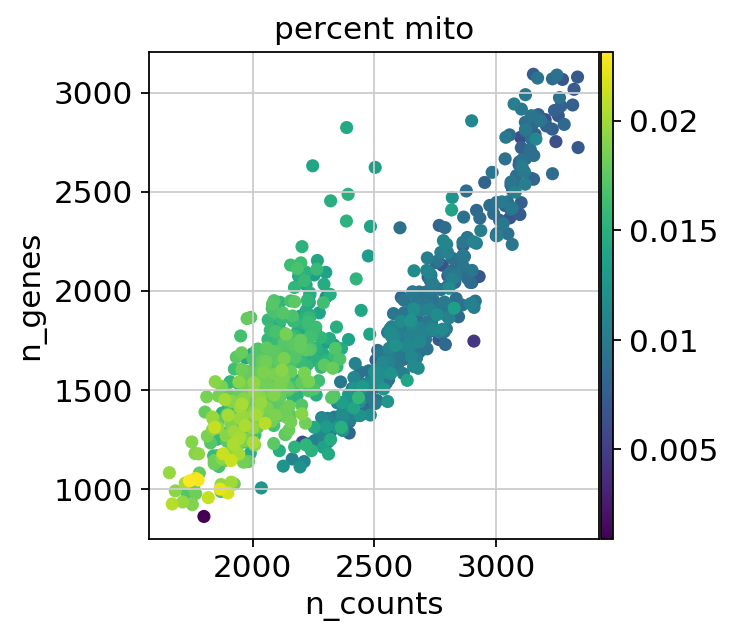

In [12]:
p1 = sc.pl.scatter(adata_GC_full, 'n_counts', 'n_genes', color='percent_mito')

In [13]:
np.median(adata_GC_full.obs['n_genes'])

1641.0

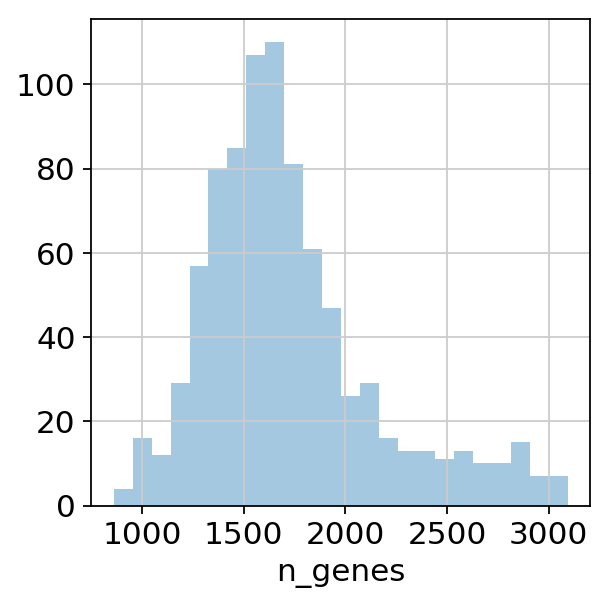

In [14]:
p3 = sns.distplot(adata_GC_full.obs['n_genes'], kde=False)
plt.show()

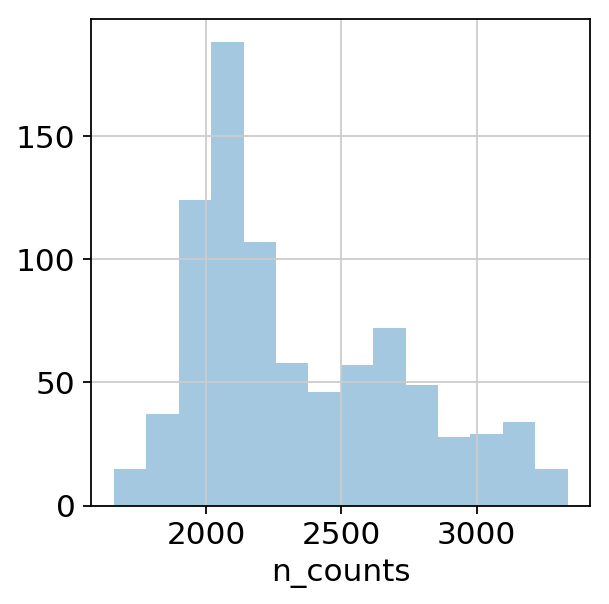

In [15]:
p3 = sns.distplot(adata_GC_full.obs['n_counts'], kde=False)
plt.show()

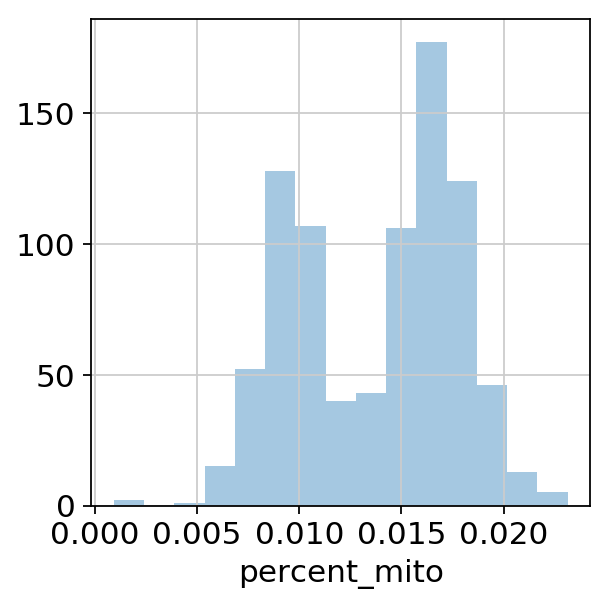

In [16]:
p3 = sns.distplot(adata_GC_full.obs['percent_mito'], kde=False)
plt.show()

In [17]:
# actual filtering

# Filer cells with less than 200 genes expressed
sc.pp.filter_cells(adata_GC_full, min_genes=200)
    
# Filer genes expressed in less than 3 cells
sc.pp.filter_genes(adata_GC_full, min_cells=3)

filtered out 154 genes that are detectedin less than 3 cells


In [18]:
# from the description of this data (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3190075) I assume it was raw, so:
# normalise and log transform
sc.pp.normalize_per_cell(adata_GC_full, counts_per_cell_after=1e4)
sc.pp.log1p(adata_GC_full)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [19]:
# mt % filtering
adata_GC_full = adata_GC_full[adata_GC_full.obs['percent_mito'] < 0.2]

# saving the raw attribute
adata_GC_full.raw = adata_GC_full

adata_GC_full.var_names_make_unique()
adata_GC_full.obs_names_make_unique()

In [20]:
adata_GC_full

AnnData object with n_obs × n_vars = 859 × 14157 
    obs: 0, 'n_counts', 'log_counts', 'n_genes', 'percent_mito'
    var: 'n_cells'

## Visualising GC data

### Filter Cell cycle genes - only for further visualisation
Per genes analysis: identify genes behaving like known cell cycle genes

Here known cyclers are not inHVGs, so doing clustering on the whole object (all genes)

In [21]:
cellcycle_adata = adata_GC_full.copy()

In [22]:
# Traspose matrix for a GENE-centered analysis
cellcycle_adata = cellcycle_adata.T
#cellcycle_adata = cellcycle_adata[filter_result.gene_subset,:]

In [23]:
cellcycle_adata.obs.index

Index(['FO538757.2', 'AP006222.2', 'RP11-206L10.9', 'LINC00115', 'FAM41C',
       'RP11-54O7.1', 'NOC2L', 'RP11-54O7.17', 'HES4', 'ISG15',
       ...
       'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'BX004987.4', 'AC145212.2',
       'AL592183.1', 'AL354822.1', 'AC004556.1', 'AC240274.1'],
      dtype='object', name='0', length=14157)

In [24]:
# Scale data to unit variance and zero mean
sc.pp.scale(cellcycle_adata, max_value=10)
# Scatter plot in PCA coordinates
sc.tl.pca(cellcycle_adata, svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:01)


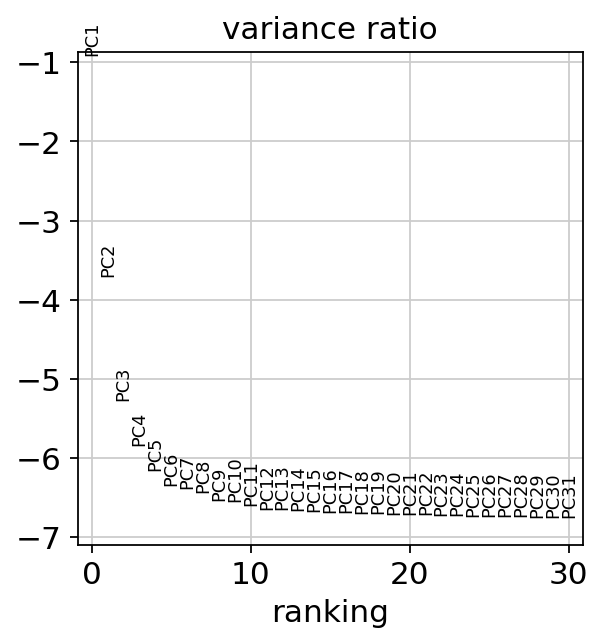

In [25]:
# Plot the variance ratio
sc.pl.pca_variance_ratio(cellcycle_adata, log=True)

In [26]:
'CDK1' in list(cellcycle_adata.obs_names) 

True

In [27]:
'MKI67' in list(cellcycle_adata.obs_names)

True

In [28]:
'CCNB2' in list(cellcycle_adata.obs_names)

True

In [29]:
'PCNA' in list(cellcycle_adata.obs_names)

True

In [30]:
# Identify genes behaving like cc genes
num_pcs = 20
# Compute a neighborhood graph of observations
sc.pp.neighbors(cellcycle_adata,n_pcs=num_pcs)
# Embed the neighborhood graph using UMAP
sc.tl.umap(cellcycle_adata)
cellcycle_adata.obs['known_cyclers'] = [i in ['CDK1','MKI67','CCNB2','PCNA'] for i in cellcycle_adata.obs_names]

computing neighbors
    using 'X_pca' with n_pcs = 20


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../opt/conda/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/conda/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../opt/conda/lib/python3.7/site-packages/umap/utils.py", line 409:
@

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


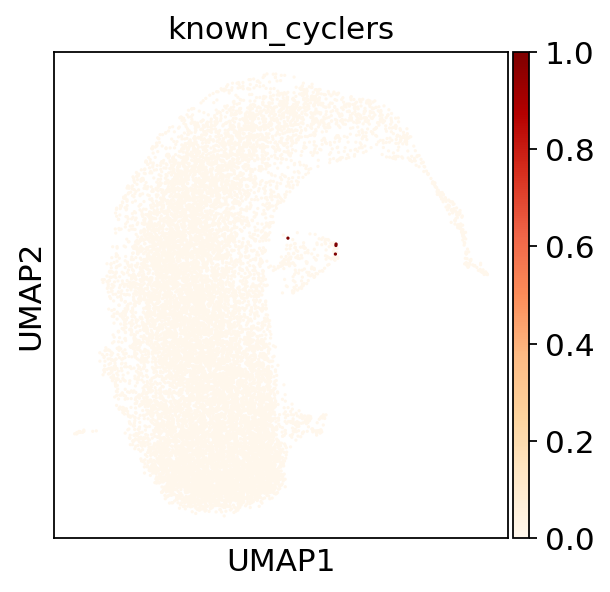

In [32]:
# Scatter plot in UMAP basis
sc.pl.umap(cellcycle_adata,color=['known_cyclers'],color_map='OrRd')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


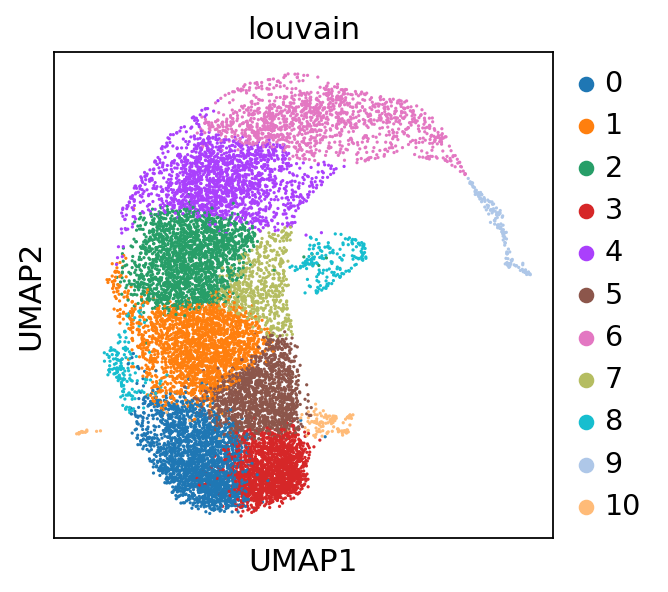

In [33]:
# Cluster GENES into subgroups using louvain: resolution < 1 to find less clusters
sc.tl.louvain(cellcycle_adata, resolution=1)
cellcycle_adata.obs['known_cyclers'] = [i in ['CDK1','MKI67','CCNB2','PCNA'] for i in cellcycle_adata.obs_names]
sc.pl.umap(cellcycle_adata, color=['louvain'])

In [34]:
# Locate genes of interests' cluster
print(cellcycle_adata.obs.loc[['CDK1','MKI67','CCNB2','PCNA'],'louvain'])


0
CDK1     8
MKI67    8
CCNB2    8
PCNA     8
Name: louvain, dtype: category
Categories (11, object): [0, 1, 2, 3, ..., 7, 8, 9, 10]


In [35]:
# Add unstructured dict-like annotation for ccgs
adata_GC_full.uns['ccgs'] = list(cellcycle_adata.obs[(cellcycle_adata.obs['louvain']=='8')].index)

# Remove cc genes
adata_GC_full = adata_GC_full[:,[i not in adata_GC_full.uns['ccgs'] for i in adata_GC_full.var_names]]

# Making a HVG-subsetted copy of the object

In [36]:
%%time
sc.pp.highly_variable_genes(adata_GC_full, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Trying to set attribute `.var` of view, making a copy.


CPU times: user 800 ms, sys: 24 ms, total: 824 ms
Wall time: 824 ms


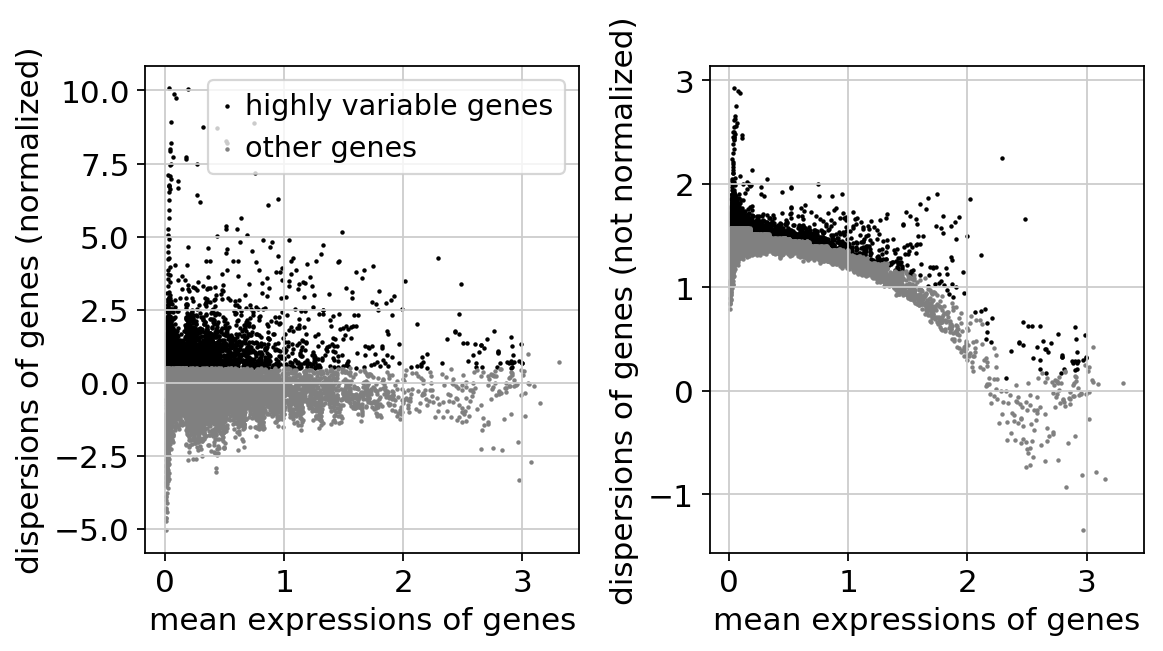

CPU times: user 1.24 s, sys: 708 ms, total: 1.95 s
Wall time: 962 ms


In [37]:
%%time
sc.pl.highly_variable_genes(adata_GC_full)

In [38]:
adata_GC_hvg = adata_GC_full[:, adata_GC_full.var['highly_variable']]

In [39]:
adata_GC_hvg

View of AnnData object with n_obs × n_vars = 859 × 3282 
    obs: 0, 'n_counts', 'log_counts', 'n_genes', 'percent_mito'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ccgs'

In [40]:
%%time
sc.pp.scale(adata_GC_hvg, max_value=10)

CPU times: user 24 ms, sys: 24 ms, total: 48 ms
Wall time: 46.2 ms


/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


_______________________________________________________________________________________________________________________

In [41]:
%%time
sc.tl.pca(adata_GC_hvg, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
CPU times: user 1.56 s, sys: 4.62 s, total: 6.18 s
Wall time: 373 ms


_______________________________________________________________________________________________________________________

In [42]:
%%time
sc.pp.neighbors(adata_GC_hvg, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)
CPU times: user 2.06 s, sys: 1.2 s, total: 3.26 s
Wall time: 1.73 s


__________________________________________________________________________________________________________________________________________________________________

In [43]:
%%time
sc.tl.umap(adata_GC_hvg, random_state=0)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
CPU times: user 2.43 s, sys: 1.46 s, total: 3.89 s
Wall time: 2.06 s


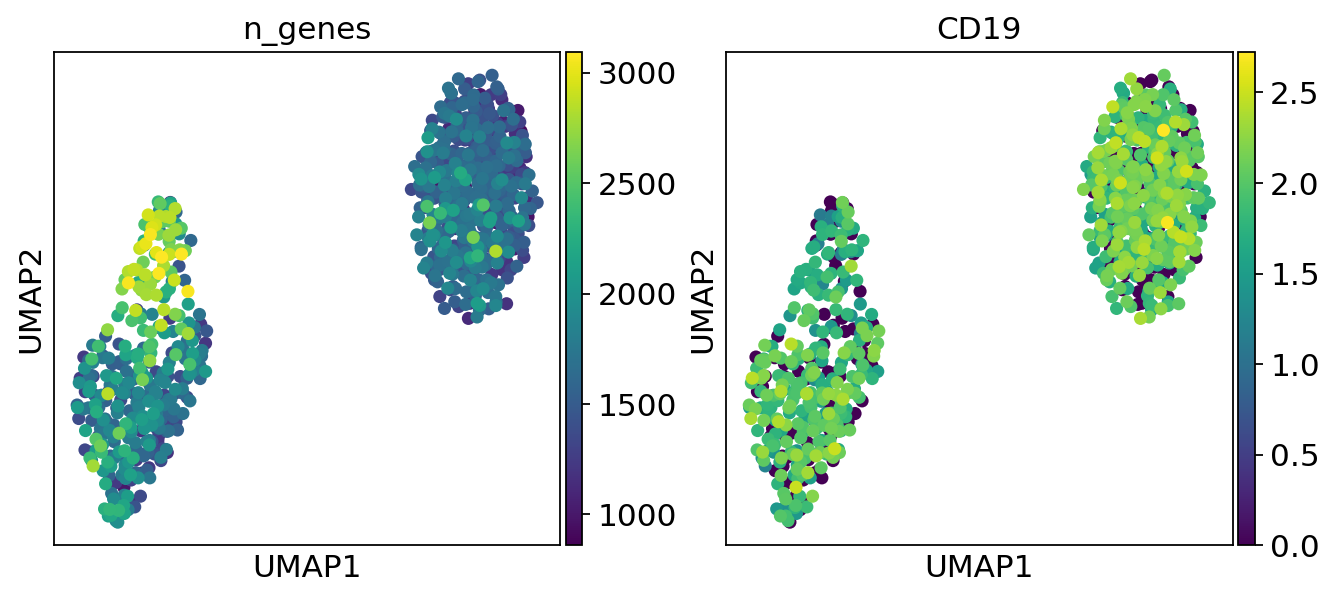

In [44]:
# after removing cell cycle genes
sc.pl.umap(adata_GC_hvg, color=['n_genes','CD19'], use_raw=True)

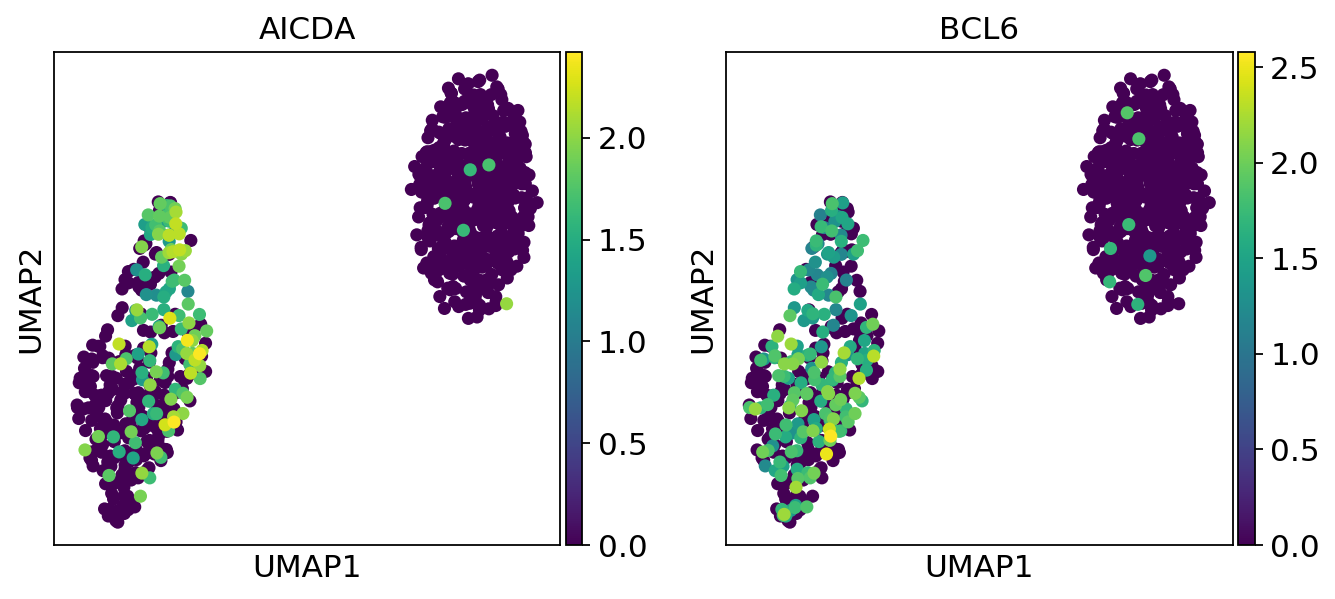

In [45]:
# GC B cell markers
sc.pl.umap(adata_GC_hvg, color=['AICDA','BCL6'], use_raw=True)

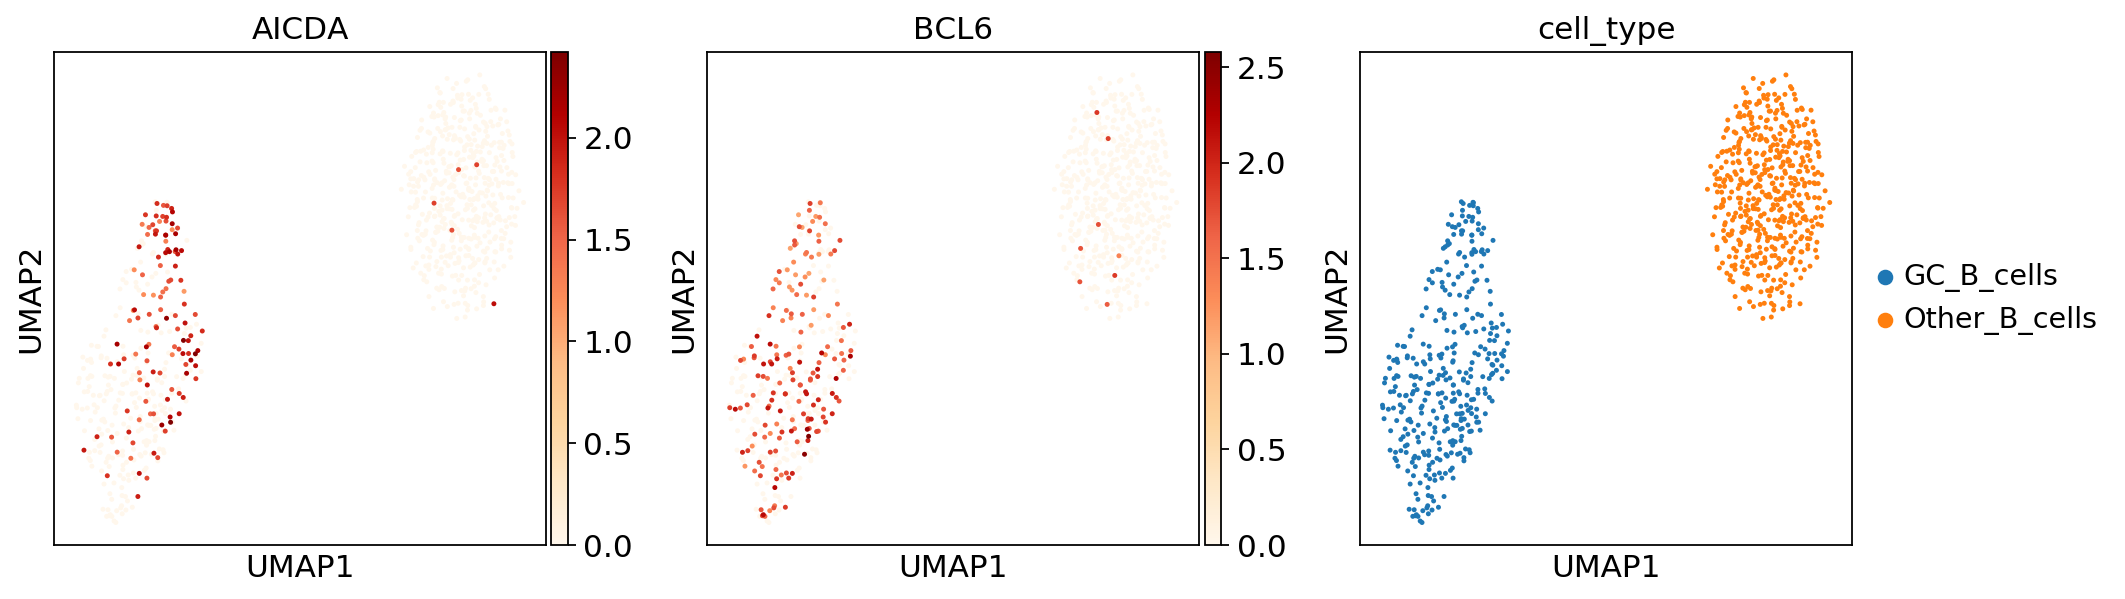

In [60]:
sc.pl.umap(adata_GC_hvg, color=['AICDA','BCL6', 'cell_type'], use_raw=True, s=20,
          cmap='OrRd', save='_Milpied_GC_B_cells.pdf')

In [49]:
adata_GC_hvg.obs.columns = ['cell_id', 'n_counts', 'log_counts', 'n_genes', 'percent_mito']

## So the cluster on the left is GC B cells, they will be used as the training data

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 2 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


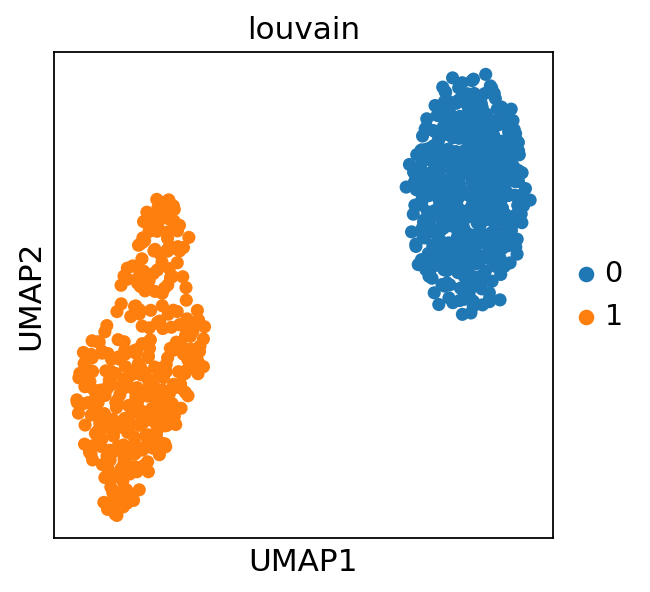

In [50]:
sc.tl.louvain(adata_GC_hvg, random_state=0, resolution=0.1)
sc.pl.umap(adata_GC_hvg,color='louvain')

In [51]:
def cell_type(adata, cell_id):
    if adata.obs.loc[cell_id,'louvain'] == '0':
        return('Other_B_cells')
    if adata.obs.loc[cell_id,'louvain'] == '1':
        return('GC_B_cells')

In [52]:
adata_GC_hvg.obs['cell_id'] = adata_GC_hvg.obs.index

In [53]:
adata_GC_hvg.obs['cell_type'] = adata_GC_hvg.obs['cell_id'].apply(lambda x: cell_type(adata_GC_hvg, x))

... storing 'cell_type' as categorical


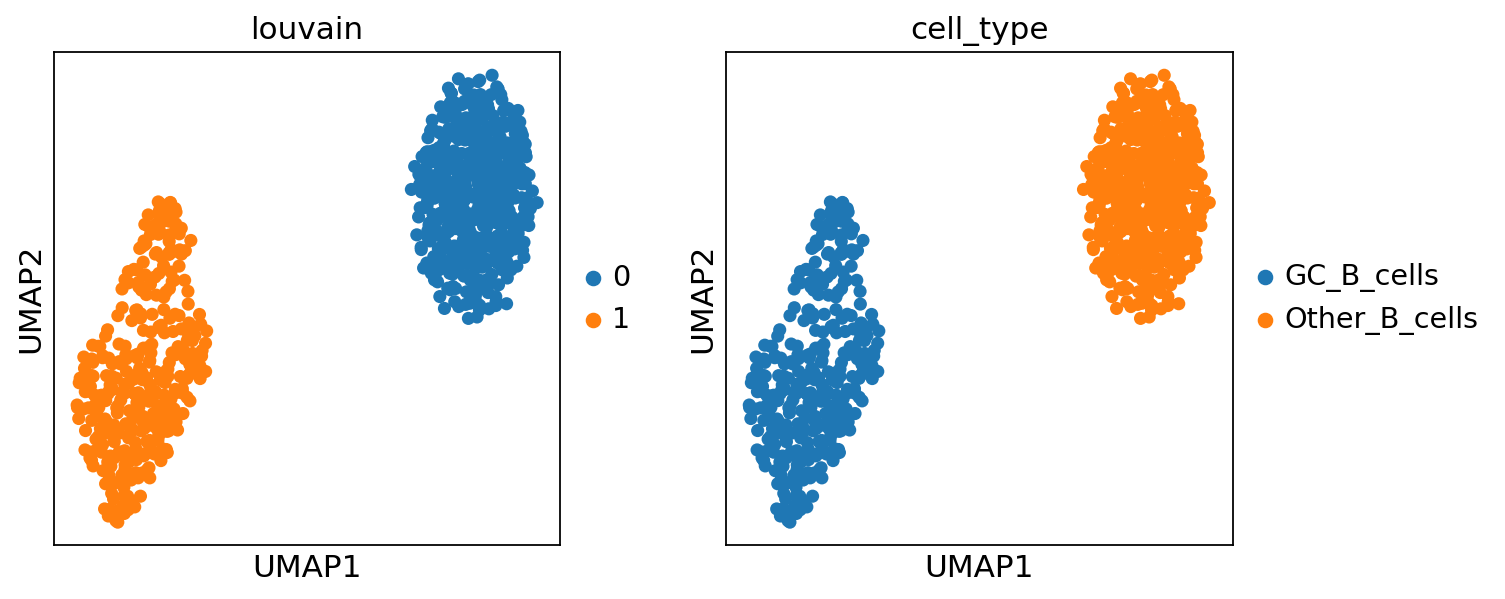

In [54]:
sc.pl.umap(adata_GC_hvg,color=['louvain','cell_type'])

In [55]:
adata_GC_hvg.write('adata_Milpied_GC_processed.h5ad')

In [56]:
adata_GC_hvg = sc.read('adata_Milpied_GC_processed.h5ad')

# Annotation - through GC B-cell data from [Milpied et al., Nature Immunology, 2018](https://www.nature.com/articles/s41590-018-0181-4#rightslink)

In [106]:
# full (all genes) version of the annotated object and test object
# here the data is only normalised and log transformed and NOT scaled
adata_train = anndata.AnnData(X=adata_GC_hvg.raw.X,
                            obs=adata_GC_hvg.obs,
                            var=adata_GC_hvg.raw.var,
                             obsm=adata_GC_hvg.obsm)

adata_test = adata_B_full

In [107]:
sc.pp.scale(adata_train, max_value=10)

In [108]:
sc.pp.scale(adata_test, max_value=10)

### Subsetting both datasets' copies to common genes only

I will train logreg on the subsetted data and tranfer the annotation onto the corresponding subsetted new data and then transfer that onto the full (with all genes) new dataset

In [109]:
# list of genes shared between blood and bone marrow data
# doing sorted on the overall list is VERY important for consistent ordering of the genes
common_genes = sorted(list(set(adata_train.var_names) & set(adata_test.var_names)))
print(len(common_genes),"genes are shared between previous training and test data \n",
      len(set(adata_train.var_names)), 'genes in training data \n',
      len((set(adata_test.var_names))), 'genes in test joint data \n')

13242 genes are shared between previous training and test data 
 14157 genes in training data 
 17976 genes in test joint data 



In [110]:
adata_train.var_names

Index(['FO538757.2', 'AP006222.2', 'RP11-206L10.9', 'LINC00115', 'FAM41C',
       'RP11-54O7.1', 'NOC2L', 'RP11-54O7.17', 'HES4', 'ISG15',
       ...
       'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'BX004987.4', 'AC145212.2',
       'AL592183.1', 'AL354822.1', 'AC004556.1', 'AC240274.1'],
      dtype='object', name='0', length=14157)

Going to copy a joint dataset with only common genes, but then transfer annotation from logreg onto the full dataset

In [111]:
adata_train_copy = adata_train[:,common_genes]

In [112]:
adata_train_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M-AS1', 'A4GALT', 'AAAS', 'AACS', 'AAED1',
       'AAGAB', 'AAK1', 'AAMDC',
       ...
       'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1',
       'ZZZ3', 'bP-21264C1.2'],
      dtype='object', name='0', length=13242)

In [113]:
adata_test_copy = adata_test[:,common_genes]
adata_test_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M-AS1', 'A4GALT', 'AAAS', 'AACS', 'AAED1',
       'AAGAB', 'AAK1', 'AAMDC',
       ...
       'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1',
       'ZZZ3', 'bP-21264C1.2'],
      dtype='object', name='index', length=13242)

In [114]:
# checking gene correspondence!
list(adata_test_copy.var_names) == list(adata_train_copy.var_names)

True

In [115]:
adata_train_copy

View of AnnData object with n_obs × n_vars = 859 × 13242 
    obs: 0, 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'louvain', 'cell_id', 'cell_type'
    var: 'n_cells'
    obsm: 'X_pca', 'X_umap'

In [116]:
np.unique(adata_train_copy.obs['cell_type'],return_counts=True)

(array(['GC_B_cells', 'Other_B_cells'], dtype=object), array([358, 501]))

# Training a logistic regression model on previously annotated SS2 data

In [117]:
adata_train_copy.obs['cell_type'].head()

0    Other_B_cells
1       GC_B_cells
2    Other_B_cells
3    Other_B_cells
4    Other_B_cells
Name: cell_type, dtype: category
Categories (2, object): [GC_B_cells, Other_B_cells]

In [118]:
celltypes_train = adata_train_copy.obs['cell_type']

In [119]:
adata_train_copy.X.shape

(859, 13242)

Using ONLY COMMON GENES

In [120]:
%%time
# training a logistic regression model
logisticRegr = LogisticRegression(max_iter = 10000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr.fit(adata_train_copy.X, celltypes_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


CPU times: user 8.19 s, sys: 21.9 s, total: 30.1 s
Wall time: 2.32 s


LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [121]:
adata_train_copy

View of AnnData object with n_obs × n_vars = 859 × 13242 
    obs: 0, 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'louvain', 'cell_id', 'cell_type'
    var: 'n_cells'
    obsm: 'X_pca', 'X_umap'

In [122]:
adata_test_copy

View of AnnData object with n_obs × n_vars = 5146 × 13242 
    obs: 'activation', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'cell_id', 'seq_batch', 'louvain', 'is_doublet_poptrim', 'cell_type', 'louvain_R9', 'louvain_B', 'louvain_NK', 'louvain_NK_1', 'louvain_myel', 'louvain_R_Tcells_7', 'louvain_R_Tcells_24568', 'louvain_R_Tcells_24568_extra', 'louvain_R_Tcells_24568_extra_extra', 'louvain_corrections', 'louvain_corrections_2', 'has_Bcell_vdj_data'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2', 'gene_ids-3', 'feature_types-3', 'genom

In [123]:
logisticRegr

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [124]:
%%time
predictions = logisticRegr.predict(adata_test_copy.X)
adata_test_copy.obs['GC_celltype_predictions'] = predictions

Trying to set attribute `.obs` of view, making a copy.


CPU times: user 952 ms, sys: 3.41 s, total: 4.36 s
Wall time: 2.18 s


In [125]:
%%time
# probabilities
probabilities = logisticRegr.predict_proba(adata_test_copy.X)
probs_adata = []
for i,clus in enumerate(adata_test_copy.obs['GC_celltype_predictions']):
    probs_adata.append(probabilities[i,logisticRegr.classes_==clus][0])


CPU times: user 536 ms, sys: 676 ms, total: 1.21 s
Wall time: 355 ms


In [126]:
list(adata_test_copy.obs.index) == list(adata_B.obs.index)

True

In [127]:
adata_B.obs['probabilities_GC'] = probs_adata

In [128]:
adata_B.obs['GC_celltype_predictions'] = adata_test_copy.obs['GC_celltype_predictions']

# Model using full objects (all genes)

### With scaling

... storing 'GC_celltype_predictions' as categorical


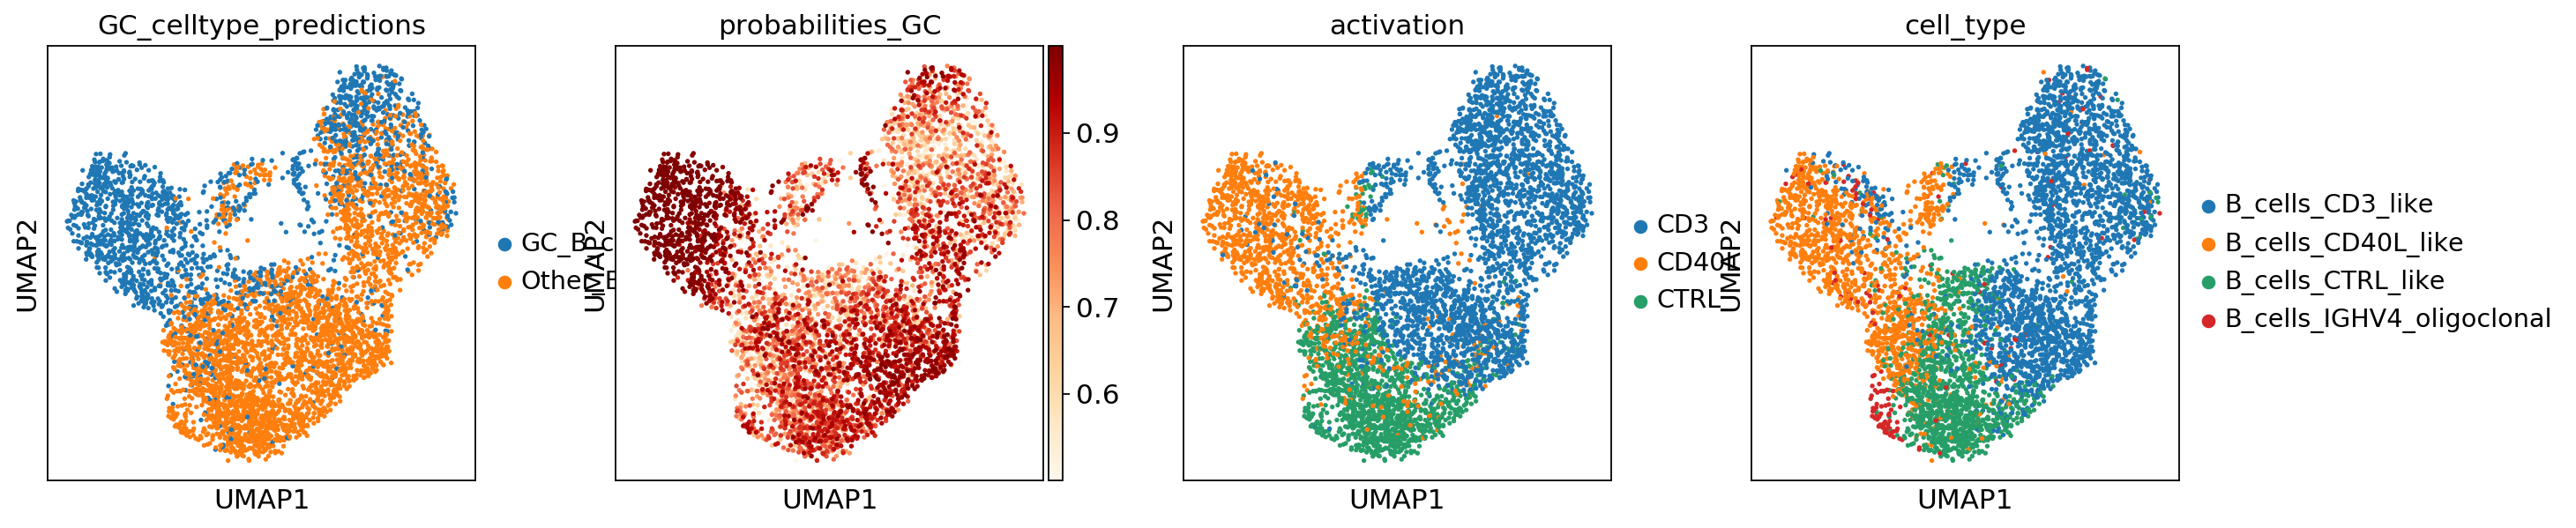

In [130]:
sc.pl.umap(adata_B,color = ['GC_celltype_predictions','probabilities_GC','activation', 'cell_type'], cmap='OrRd')

##### saving figures

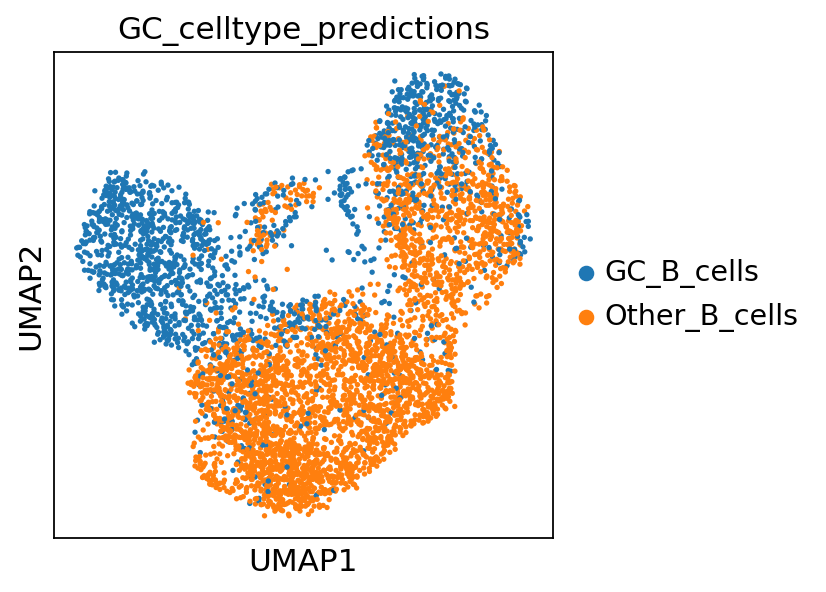

In [131]:
sc.pl.umap(adata_B,color = ['GC_celltype_predictions'], save='_B_cells_GC_celltype_predictions.pdf')

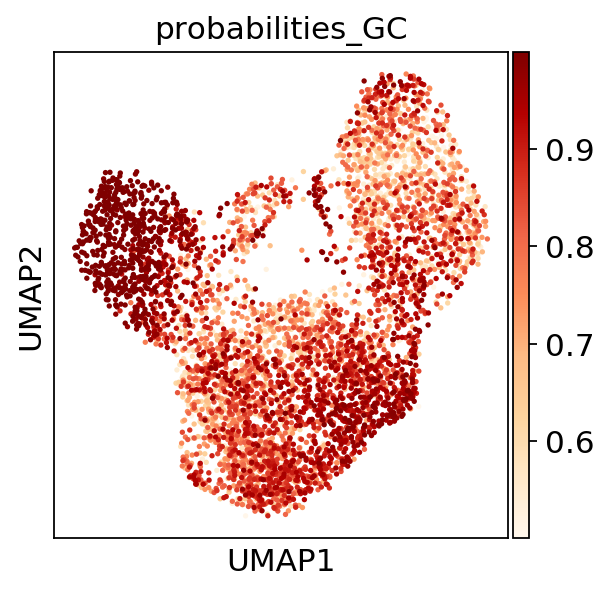

In [132]:
sc.pl.umap(adata_B,color = ['probabilities_GC'], cmap='OrRd', save='_B_cells_probabilities_GC.pdf')

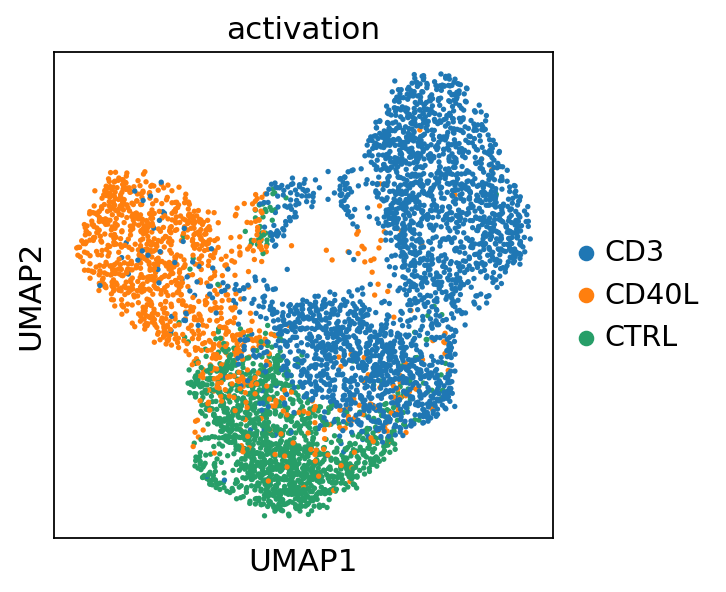

In [133]:
sc.pl.umap(adata_B,color = ['activation'], save='_B_cells_activation.pdf')

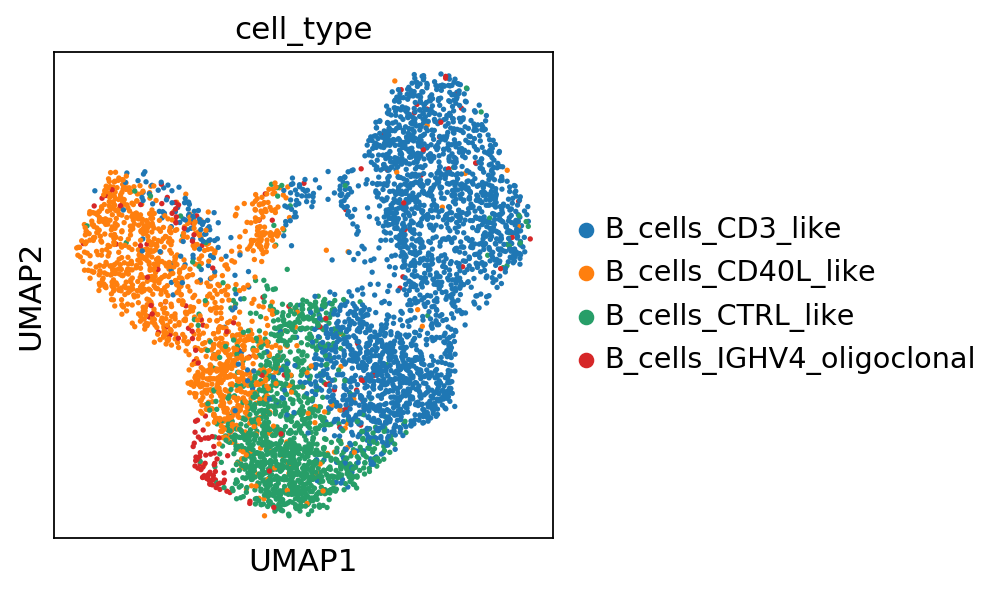

In [134]:
sc.pl.umap(adata_B,color = ['cell_type'])

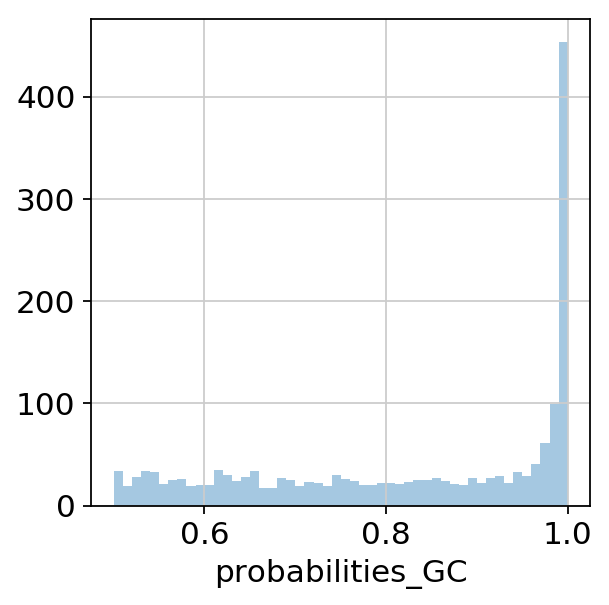

In [136]:
p3 = sns.distplot(adata_B[adata_B.obs['GC_celltype_predictions'] == 'GC_B_cells'].obs['probabilities_GC'], 
                  bins=50, kde=False)
plt.show()

In [137]:
np.median(adata_B[adata_B.obs['GC_celltype_predictions'] == 'GC_B_cells'].obs['probabilities_GC'])

0.8653175580006297

In [7]:
adata_B.write('./adata_10X_B_cells_predicted_GC_phenotype.h5ad')

In [8]:
adata_B = sc.read('./adata_10X_B_cells_predicted_GC_phenotype.h5ad')

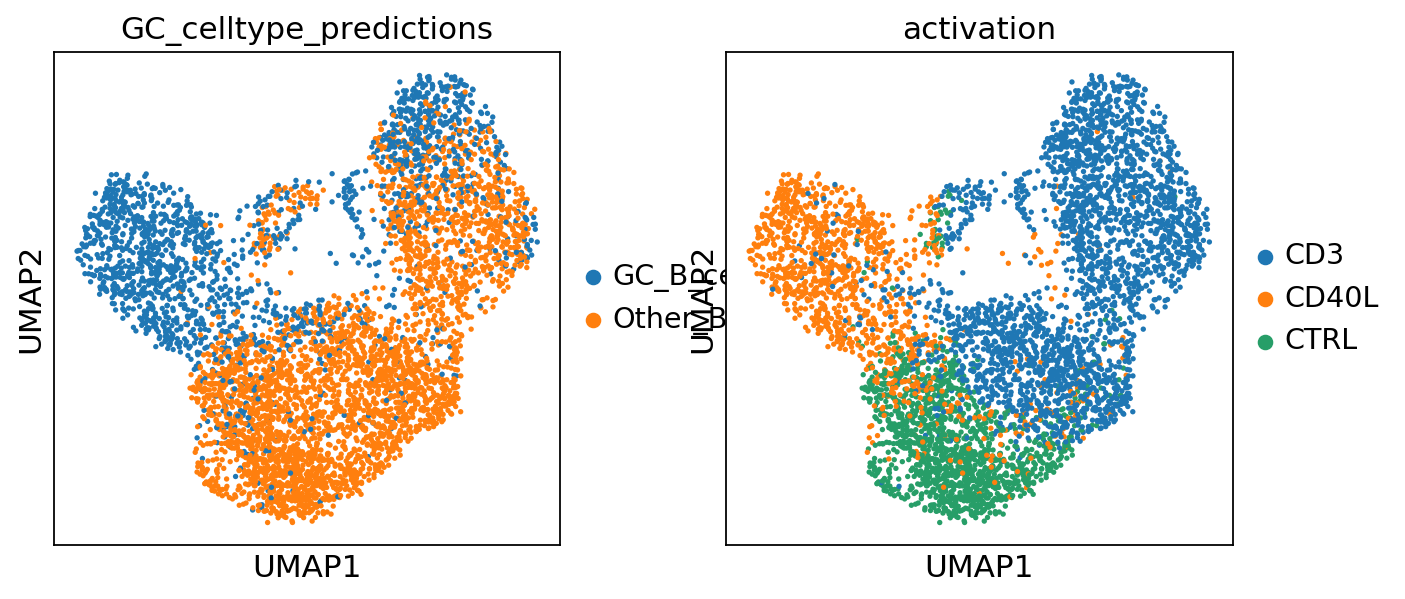

In [5]:
sc.pl.umap(adata_B,color=['GC_celltype_predictions','activation'])

### DE analysis with limma on healthy B cells: GC_B_cells vs Other_B_cells

In [6]:
# creating also the full object (all genes) - only normalised and log transformed
adata_B_full = anndata.AnnData(X=adata_B.raw.X,
                            obs=adata_B.obs,
                            var=adata_B.raw.var,
                            obsm=adata_B.obsm)

In [7]:
adata_B_full_nonCVID = adata_B_full[adata_B_full.obs['condition'] == 'CONTROL']

In [8]:
adata_B_full_nonCVID

View of AnnData object with n_obs × n_vars = 2792 × 17976 
    obs: 'activation', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'cell_id', 'seq_batch', 'louvain', 'is_doublet_poptrim', 'cell_type', 'louvain_R9', 'louvain_B', 'louvain_NK', 'louvain_NK_1', 'louvain_myel', 'louvain_R_Tcells_7', 'louvain_R_Tcells_24568', 'louvain_R_Tcells_24568_extra', 'louvain_R_Tcells_24568_extra_extra', 'louvain_corrections', 'louvain_corrections_2', 'has_Bcell_vdj_data', 'probabilities_GC', 'GC_celltype_predictions'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_n

In [10]:
# marker calling

#t = adata_hvg.X.toarray().T
t = adata_B_full_nonCVID.X.toarray().T
df = pd.DataFrame(data=t, columns= adata_B_full_nonCVID.obs.index, index=adata_B_full_nonCVID.var_names)

meta_df = pd.DataFrame(data={'Cell':list(adata_B_full_nonCVID.obs.index),
                             'cell_type':[ str(i) for i in adata_B_full_nonCVID.obs['GC_celltype_predictions']],
                             'sample':[ str(i) for i in adata_B_full_nonCVID.obs['sample']]})
meta_df.set_index('Cell', inplace=True)

In [11]:
meta_df

cell_type                   sample covariate
Cell                                                                
AAACGGGAGCTCCCAG-1  Other_B_cells  Immunodeficiency8103074         3
AAACGGGAGTCCAGGA-1  Other_B_cells  Immunodeficiency8103074         3
AAACGGGAGTCTCCTC-1  Other_B_cells  Immunodeficiency8103074         3
AAACGGGCATTCGACA-1  Other_B_cells  Immunodeficiency8103074         3
AAAGATGGTCTCTCTG-1  Other_B_cells  Immunodeficiency8103074         3
...                           ...                      ...       ...
TTTGGTTTCTTCATGT-1  Other_B_cells  Immunodeficiency8103077         4
TTTGTCAAGCCATCGC-1     GC_B_cells  Immunodeficiency8103077         4
TTTGTCAGTAAATGTG-1     GC_B_cells  Immunodeficiency8103077         4
TTTGTCAGTATCTGCA-1  Other_B_cells  Immunodeficiency8103077         4
TTTGTCAGTCAATACC-1  Other_B_cells  Immunodeficiency8103077         4

[2792 rows x 3 columns]

In [12]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['GC_B_cells', 'Other_B_cells'], dtype=object), array([ 885, 1907]))

In [13]:
%load_ext rpy2.ipython

In [14]:
outpath = './10X_B_cells_DE_limma/'

In [15]:
%%R
library(limma)
library(edgeR)

In [16]:
meta_df.reset_index(inplace=True)

In [17]:
meta_df

Cell      cell_type                   sample covariate
0     AAACGGGAGCTCCCAG-1  Other_B_cells  Immunodeficiency8103074         3
1     AAACGGGAGTCCAGGA-1  Other_B_cells  Immunodeficiency8103074         3
2     AAACGGGAGTCTCCTC-1  Other_B_cells  Immunodeficiency8103074         3
3     AAACGGGCATTCGACA-1  Other_B_cells  Immunodeficiency8103074         3
4     AAAGATGGTCTCTCTG-1  Other_B_cells  Immunodeficiency8103074         3
...                  ...            ...                      ...       ...
2787  TTTGGTTTCTTCATGT-1  Other_B_cells  Immunodeficiency8103077         4
2788  TTTGTCAAGCCATCGC-1     GC_B_cells  Immunodeficiency8103077         4
2789  TTTGTCAGTAAATGTG-1     GC_B_cells  Immunodeficiency8103077         4
2790  TTTGTCAGTATCTGCA-1  Other_B_cells  Immunodeficiency8103077         4
2791  TTTGTCAGTCAATACC-1  Other_B_cells  Immunodeficiency8103077         4

[2792 rows x 4 columns]

In [18]:
# because R replace '-' with '.' in df for some reason
def rename_Cell(cell_id):
    return(cell_id.replace('-','.'))

In [19]:
meta_df['Cell'] = meta_df['Cell'].apply(lambda x: rename_Cell(x))

In [20]:
meta_df

Cell      cell_type                   sample covariate
0     AAACGGGAGCTCCCAG.1  Other_B_cells  Immunodeficiency8103074         3
1     AAACGGGAGTCCAGGA.1  Other_B_cells  Immunodeficiency8103074         3
2     AAACGGGAGTCTCCTC.1  Other_B_cells  Immunodeficiency8103074         3
3     AAACGGGCATTCGACA.1  Other_B_cells  Immunodeficiency8103074         3
4     AAAGATGGTCTCTCTG.1  Other_B_cells  Immunodeficiency8103074         3
...                  ...            ...                      ...       ...
2787  TTTGGTTTCTTCATGT.1  Other_B_cells  Immunodeficiency8103077         4
2788  TTTGTCAAGCCATCGC.1     GC_B_cells  Immunodeficiency8103077         4
2789  TTTGTCAGTAAATGTG.1     GC_B_cells  Immunodeficiency8103077         4
2790  TTTGTCAGTATCTGCA.1  Other_B_cells  Immunodeficiency8103077         4
2791  TTTGTCAGTCAATACC.1  Other_B_cells  Immunodeficiency8103077         4

[2792 rows x 4 columns]

In [34]:
df

index                AAAGATGGTAAACCTC-1  AAAGATGTCTGGCGAC-1  \
index                                                         
RP11-34P13.7                        0.0                 0.0   
FO538757.3                          0.0                 0.0   
FO538757.2                          0.0                 0.0   
AP006222.2                          0.0                 0.0   
RP5-857K21.4                        0.0                 0.0   
...                                 ...                 ...   
XXbac-BPGBPG55C20.3                 0.0                 0.0   
RP13-735L24.1                       0.0                 0.0   
CDH2                                0.0                 0.0   
HPD                                 0.0                 0.0   
PMEL                                0.0                 0.0   

index                AAAGCAAAGCGGATCA-1  AAAGCAACAGTCGTGC-1  \
index                                                         
RP11-34P13.7                        0.0                 0.0   
FO538757.3                          0.0                 0.0   
FO538757.2                          0.0                 0.0   
AP006222.2                          0.0                 0.0   
RP5-857K21.4                        0.0                 0.0   
...                                 ...                 ...   
XXbac-BPGBPG55C20.3                 0.0                 0.0   
RP13-735L24.1                       0.0                 0.0   
CDH2                                0.0                 0.0   
HPD                                 0.0                 0.0   
PMEL                                0.0                 0.0   

index                AAAGCAAGTAGCCTAT-1  AAAGCAATCCGCGTTT-1  \
index                                                         
RP11-34P13.7                        0.0            0.000000   
FO538757.3                          0.0            0.000000   
FO538757.2                          0.0            2.279746   
AP006222.2                          0.0            0.000000   
RP5-857K21.4                        0.0            0.000000   
...                                 ...                 ...   
XXbac-BPGBPG55C20.3                 0.0            0.000000   
RP13-735L24.1                       0.0            0.000000   
CDH2                                0.0            0.000000   
HPD                                 0.0            0.000000   
PMEL                                0.0            0.000000   

index                AAAGTAGAGGCCGAAT-1  AAAGTAGAGTTTAGGA-1  \
index                                                         
RP11-34P13.7                        0.0                 0.0   
FO538757.3                          0.0                 0.0   
FO538757.2                          0.0                 0.0   
AP006222.2                          0.0                 0.0   
RP5-857K21.4                        0.0                 0.0   
...                                 ...                 ...   
XXbac-BPGBPG55C20.3                 0.0                 0.0   
RP13-735L24.1                       0.0                 0.0   
CDH2                                0.0                 0.0   
HPD                                 0.0                 0.0   
PMEL                                0.0                 0.0   

index                AAAGTAGCACACATGT-1  AAAGTAGCACGGTGTC-1  ...  \
index                                                        ...   
RP11-34P13.7                        0.0                 0.0  ...   
FO538757.3                          0.0                 0.0  ...   
FO538757.2                          0.0                 0.0  ...   
AP006222.2                          0.0                 0.0  ...   
RP5-857K21.4                        0.0                 0.0  ...   
...                                 ...                 ...  ...   
XXbac-BPGBPG55C20.3                 0.0                 0.0  ...   
RP13-735L24.1                       0.0                 0.0  ...   
CDH2                                0.0 

In [21]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['GC_B_cells', 'Other_B_cells'], dtype=object), array([ 885, 1907]))

In [22]:
# doing for all nonCVID B cells, comparing GC-like B cells vs other B cells
case = 'GC_B_cells'
ctrl = 'Other_B_cells'

In [23]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, case, '_vs_', ctrl, 'non-CVID_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "Other_B_cells" "GC_B_cells"   


R[write to console]: 2792 shared cells



[1] "ctrl" "case"


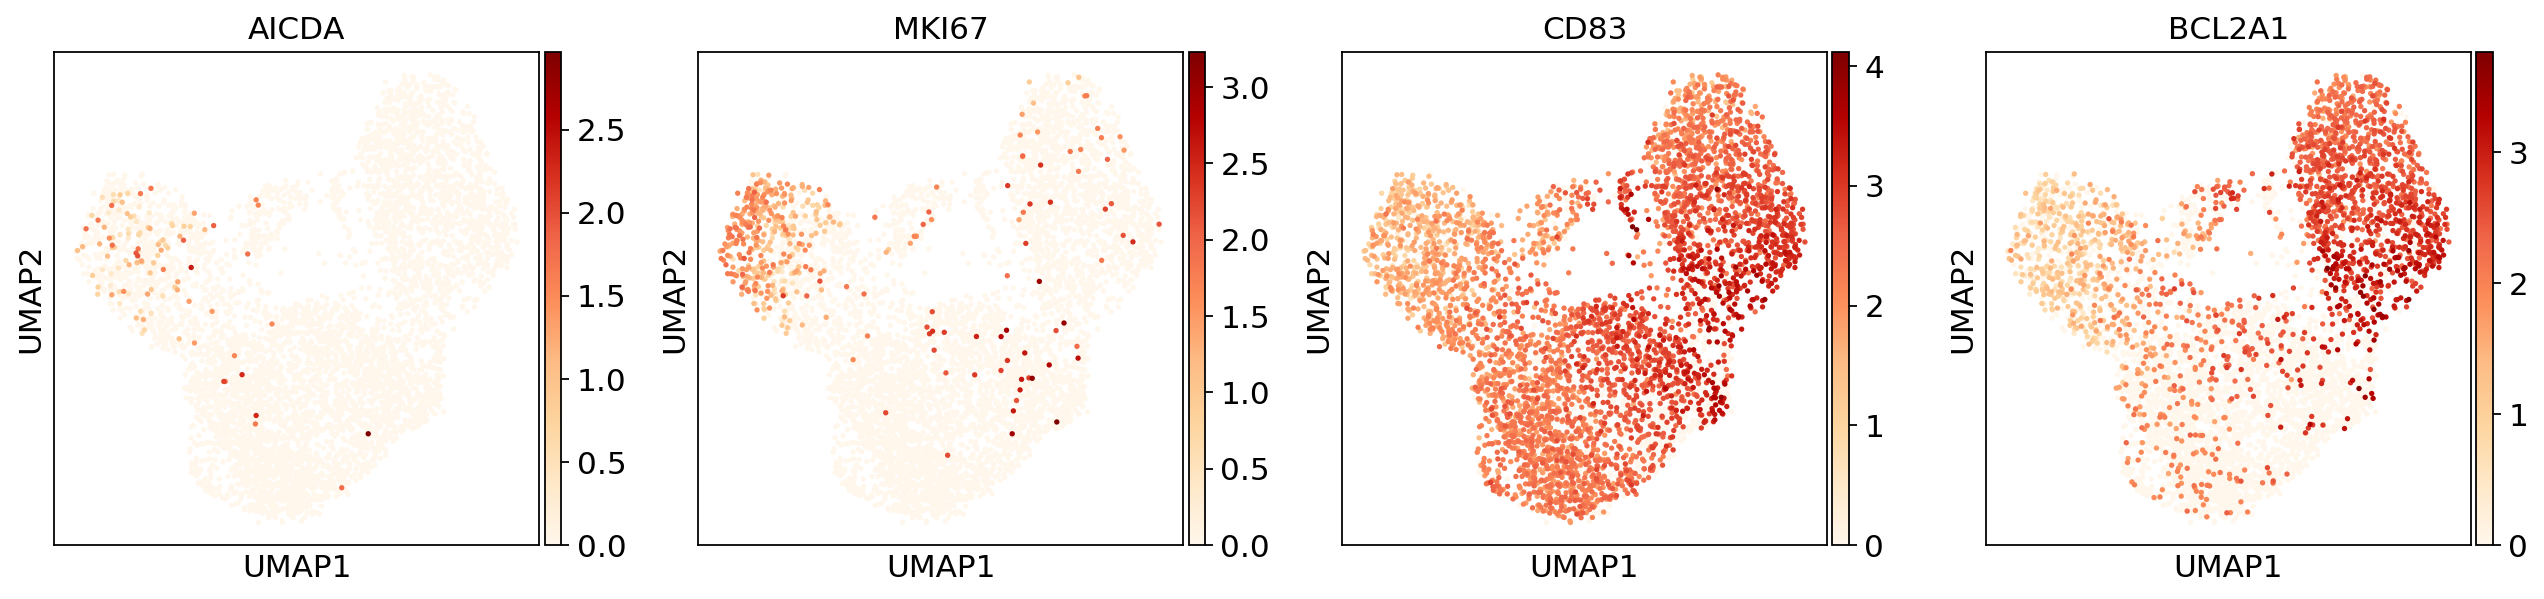

In [16]:
sc.pl.umap(adata_B,color=['AICDA','MKI67','CD83','BCL2A1'], cmap='OrRd', use_raw=True)

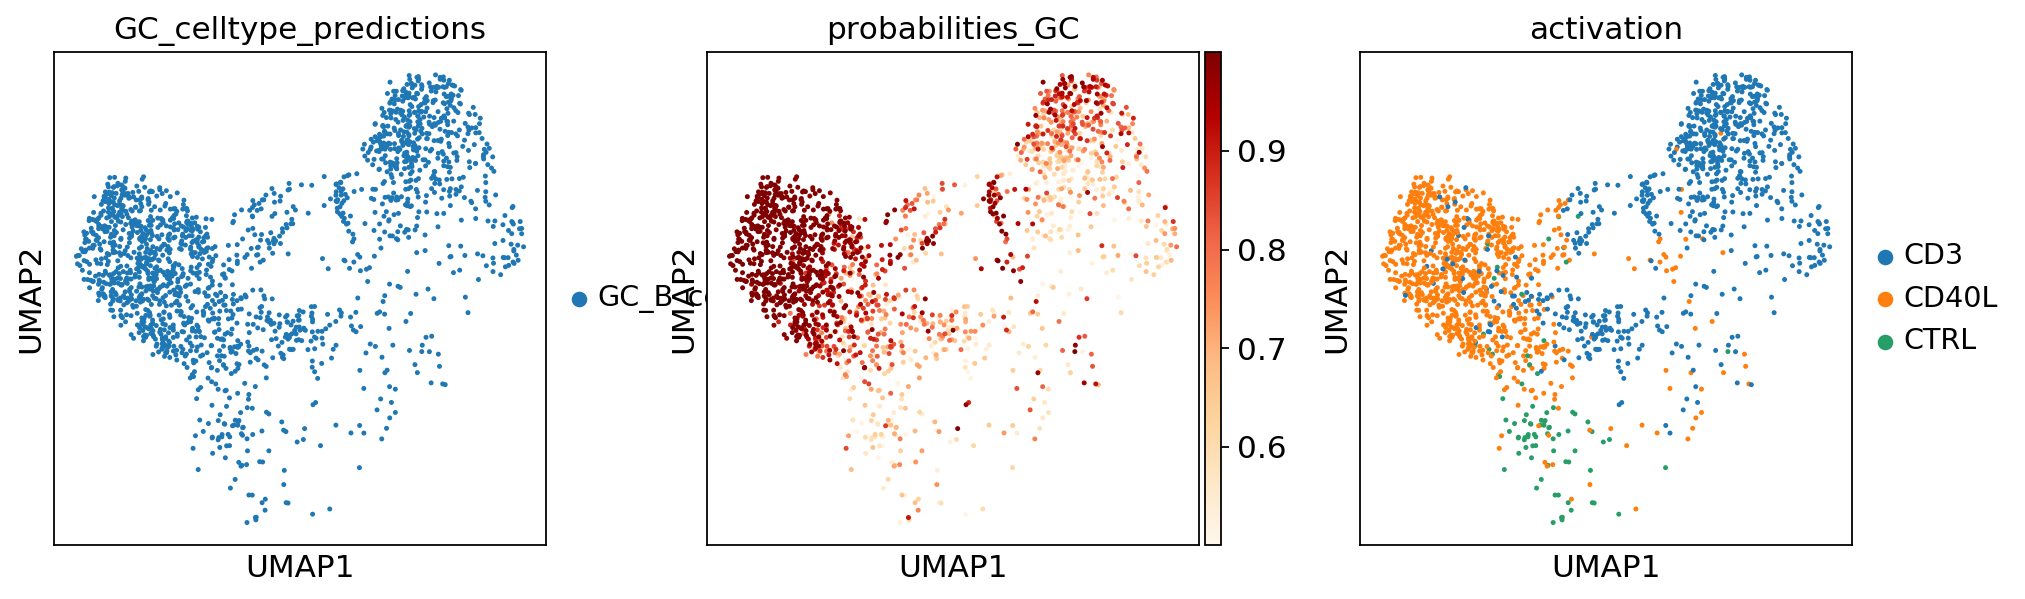

In [17]:
sc.pl.umap(adata_B[adata_B.obs['GC_celltype_predictions'] == 'GC_B_cells'],
           color=['GC_celltype_predictions','probabilities_GC','activation'], cmap='OrRd',
          size=20)

### DE analysis with limma on GC-like cells: CVID vs CONTROL (healthy)

In [23]:
# marker calling

#t = adata_hvg.X.toarray().T
t = adata_B_full.X.toarray().T
df = pd.DataFrame(data=t, columns= adata_B_full.obs.index, index=adata_B_full.var_names)

meta_df = pd.DataFrame(data={'Cell':list(adata_B_full.obs.index),
                             'cell_type':[ str(i) for i in adata_B_full.obs['GC_prediction_and_condition']],
                             'sample':[ str(i) for i in adata_B_full.obs['sample']]})
meta_df.set_index('Cell', inplace=True)

In [24]:
meta_df

cell_type                   sample covariate
Cell                                                                        
AAAGATGGTAAACCTC-1     Other_B_cells_CVID  Immunodeficiency8103070         1
AAAGATGTCTGGCGAC-1     Other_B_cells_CVID  Immunodeficiency8103070         1
AAAGCAAAGCGGATCA-1     Other_B_cells_CVID  Immunodeficiency8103070         1
AAAGCAACAGTCGTGC-1     Other_B_cells_CVID  Immunodeficiency8103070         1
AAAGCAAGTAGCCTAT-1     Other_B_cells_CVID  Immunodeficiency8103070         1
...                                   ...                      ...       ...
TTTGGTTTCTTCATGT-1  Other_B_cells_CONTROL  Immunodeficiency8103077         4
TTTGTCAAGCCATCGC-1     GC_B_cells_CONTROL  Immunodeficiency8103077         4
TTTGTCAGTAAATGTG-1     GC_B_cells_CONTROL  Immunodeficiency8103077         4
TTTGTCAGTATCTGCA-1  Other_B_cells_CONTROL  Immunodeficiency8103077         4
TTTGTCAGTCAATACC-1  Other_B_cells_CONTROL  Immunodeficiency8103077         4

[5146 rows x 3 columns]

In [25]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['GC_B_cells_CONTROL', 'GC_B_cells_CVID', 'Other_B_cells_CONTROL',
        'Other_B_cells_CVID'], dtype=object), array([ 885,  907, 1907, 1447]))

In [26]:
%load_ext rpy2.ipython

In [27]:
outpath = './10X_B_cells_DE_limma/'

In [28]:
%%R
library(limma)
library(edgeR)

In [29]:
meta_df.reset_index(inplace=True)

In [30]:
meta_df

Cell              cell_type                   sample  \
0     AAAGATGGTAAACCTC-1     Other_B_cells_CVID  Immunodeficiency8103070   
1     AAAGATGTCTGGCGAC-1     Other_B_cells_CVID  Immunodeficiency8103070   
2     AAAGCAAAGCGGATCA-1     Other_B_cells_CVID  Immunodeficiency8103070   
3     AAAGCAACAGTCGTGC-1     Other_B_cells_CVID  Immunodeficiency8103070   
4     AAAGCAAGTAGCCTAT-1     Other_B_cells_CVID  Immunodeficiency8103070   
...                  ...                    ...                      ...   
5141  TTTGGTTTCTTCATGT-1  Other_B_cells_CONTROL  Immunodeficiency8103077   
5142  TTTGTCAAGCCATCGC-1     GC_B_cells_CONTROL  Immunodeficiency8103077   
5143  TTTGTCAGTAAATGTG-1     GC_B_cells_CONTROL  Immunodeficiency8103077   
5144  TTTGTCAGTATCTGCA-1  Other_B_cells_CONTROL  Immunodeficiency8103077   
5145  TTTGTCAGTCAATACC-1  Other_B_cells_CONTROL  Immunodeficiency8103077   

     covariate  
0            1  
1            1  
2            1  
3            1  
4            1  
...        ...  
5141         4  
5142         4  
5143         4  
5144         4  
5145         4  

[5146 rows x 4 columns]

In [31]:
# because R replace '-' with '.' in df for some reason
def rename_Cell(cell_id):
    return(cell_id.replace('-','.'))

In [32]:
meta_df['Cell'] = meta_df['Cell'].apply(lambda x: rename_Cell(x))

In [33]:
meta_df

Cell              cell_type                   sample  \
0     AAAGATGGTAAACCTC.1     Other_B_cells_CVID  Immunodeficiency8103070   
1     AAAGATGTCTGGCGAC.1     Other_B_cells_CVID  Immunodeficiency8103070   
2     AAAGCAAAGCGGATCA.1     Other_B_cells_CVID  Immunodeficiency8103070   
3     AAAGCAACAGTCGTGC.1     Other_B_cells_CVID  Immunodeficiency8103070   
4     AAAGCAAGTAGCCTAT.1     Other_B_cells_CVID  Immunodeficiency8103070   
...                  ...                    ...                      ...   
5141  TTTGGTTTCTTCATGT.1  Other_B_cells_CONTROL  Immunodeficiency8103077   
5142  TTTGTCAAGCCATCGC.1     GC_B_cells_CONTROL  Immunodeficiency8103077   
5143  TTTGTCAGTAAATGTG.1     GC_B_cells_CONTROL  Immunodeficiency8103077   
5144  TTTGTCAGTATCTGCA.1  Other_B_cells_CONTROL  Immunodeficiency8103077   
5145  TTTGTCAGTCAATACC.1  Other_B_cells_CONTROL  Immunodeficiency8103077   

     covariate  
0            1  
1            1  
2            1  
3            1  
4            1  
...        ...  
5141         4  
5142         4  
5143         4  
5144         4  
5145         4  

[5146 rows x 4 columns]

In [34]:
df

index                AAAGATGGTAAACCTC-1  AAAGATGTCTGGCGAC-1  \
index                                                         
RP11-34P13.7                        0.0                 0.0   
FO538757.3                          0.0                 0.0   
FO538757.2                          0.0                 0.0   
AP006222.2                          0.0                 0.0   
RP5-857K21.4                        0.0                 0.0   
...                                 ...                 ...   
XXbac-BPGBPG55C20.3                 0.0                 0.0   
RP13-735L24.1                       0.0                 0.0   
CDH2                                0.0                 0.0   
HPD                                 0.0                 0.0   
PMEL                                0.0                 0.0   

index                AAAGCAAAGCGGATCA-1  AAAGCAACAGTCGTGC-1  \
index                                                         
RP11-34P13.7                        0.0                 0.0   
FO538757.3                          0.0                 0.0   
FO538757.2                          0.0                 0.0   
AP006222.2                          0.0                 0.0   
RP5-857K21.4                        0.0                 0.0   
...                                 ...                 ...   
XXbac-BPGBPG55C20.3                 0.0                 0.0   
RP13-735L24.1                       0.0                 0.0   
CDH2                                0.0                 0.0   
HPD                                 0.0                 0.0   
PMEL                                0.0                 0.0   

index                AAAGCAAGTAGCCTAT-1  AAAGCAATCCGCGTTT-1  \
index                                                         
RP11-34P13.7                        0.0            0.000000   
FO538757.3                          0.0            0.000000   
FO538757.2                          0.0            2.279746   
AP006222.2                          0.0            0.000000   
RP5-857K21.4                        0.0            0.000000   
...                                 ...                 ...   
XXbac-BPGBPG55C20.3                 0.0            0.000000   
RP13-735L24.1                       0.0            0.000000   
CDH2                                0.0            0.000000   
HPD                                 0.0            0.000000   
PMEL                                0.0            0.000000   

index                AAAGTAGAGGCCGAAT-1  AAAGTAGAGTTTAGGA-1  \
index                                                         
RP11-34P13.7                        0.0                 0.0   
FO538757.3                          0.0                 0.0   
FO538757.2                          0.0                 0.0   
AP006222.2                          0.0                 0.0   
RP5-857K21.4                        0.0                 0.0   
...                                 ...                 ...   
XXbac-BPGBPG55C20.3                 0.0                 0.0   
RP13-735L24.1                       0.0                 0.0   
CDH2                                0.0                 0.0   
HPD                                 0.0                 0.0   
PMEL                                0.0                 0.0   

index                AAAGTAGCACACATGT-1  AAAGTAGCACGGTGTC-1  ...  \
index                                                        ...   
RP11-34P13.7                        0.0                 0.0  ...   
FO538757.3                          0.0                 0.0  ...   
FO538757.2                          0.0                 0.0  ...   
AP006222.2                          0.0                 0.0  ...   
RP5-857K21.4                        0.0                 0.0  ...   
...                                 ...                 ...  ...   
XXbac-BPGBPG55C20.3                 0.0                 0.0  ...   
RP13-735L24.1                       0.0                 0.0  ...   
CDH2                                0.0 

In [35]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['GC_B_cells_CONTROL', 'GC_B_cells_CVID', 'Other_B_cells_CONTROL',
        'Other_B_cells_CVID'], dtype=object), array([ 885,  907, 1907, 1447]))

In [36]:
# doing for the CTRL, CD3 and CD40L B cells (ignoring IGHV4 oligoclonal B cells)
# for all T cell groups except for MT-high T cells and Proliferating T cells
case = 'GC_B_cells_CVID'
ctrl = 'GC_B_cells_CONTROL'

In [37]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)
covariates = meta_df$covariate

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

#design.matrix <- model.matrix(~ 0 + cluster_type + covariates)
design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, case, '_vs_', ctrl, '_limma_DEGs.csv'), row.names = F, col.names = T, quote = F)

[1] "GC_B_cells_CVID"    "GC_B_cells_CONTROL"


R[write to console]: 1792 shared cells



[1] "case" "ctrl"
